In [1]:
import pandas as pd
import pybasilica.run as run
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import seaborn as sns
import sklearn.metrics
import torch.nn.functional as F
from tqdm import tqdm
from pyro.distributions import constraints

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/basilica-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_g = pd.read_csv("test_datasets/counts_sbs.N150.G3.csv")
m_sbs = m_g.drop(["groups"], axis=1)
g_sbs = m_g["groups"].tolist() 
cosmic_sbs = pd.read_csv("test_datasets/COSMIC_filt.csv", index_col=0) 

In [3]:
m_g = pd.read_csv("test_datasets/counts_dbs.N150.G3.csv")
m_dbs = m_g.drop(["groups"], axis=1)
g_dbs = m_g["groups"].tolist()
cosmic_dbs = pd.read_csv("test_datasets/COSMIC_dbs.csv", index_col=0) 

In [4]:
obj_sbs = run.fit(
    x=m_sbs, 
    k_list=[3,4], 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=2000, 
    # cluster=[3],
    dirichlet_prior=True,
    beta_fixed=cosmic_sbs.loc[["SBS1","SBS3","SBS5"]], 
    store_parameters = True, 
    seed_list=[30],
    nonparametric=False,
    store_fits=True, enumer="parallel"
    )


ELBO 48017.537012: 100%|██████████| 2000/2000 [00:06<00:00, 293.26it/s]


In [152]:
obj_dbs = run.fit(
    x=m_dbs, 
    k_list=3, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=1000, 
    # cluster=[3],
    dirichlet_prior=True,
    beta_fixed=cosmic_dbs.loc[["DBS3","DBS5"]], 
    store_parameters=False, 
    seed_list=[30],
    store_fits=True
    )


ELBO 132427.058856: 100%|██████████| 1000/1000 [00:03<00:00, 304.93it/s]


In [166]:
input_alpha = [obj_sbs.params["alpha"], obj_dbs.params["alpha"]]
obj_clust = run.fit(
    alpha=input_alpha,
    lr=0.005, 
    # optim_gamma=0.1,
    n_steps=100, 
    cluster=[6],
    seed_list=[33],
    nonparametric=True,
    store_fits=True,
    autoguide=True
    )


Bar desc:   0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Expected parameter concentration (Tensor of shape (150, 7)) of distribution Dirichlet(concentration: torch.Size([150, 7])) to satisfy the constraint IndependentConstraint(GreaterThan(lower_bound=0.0), 1), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<IndexBackward0>)
             Trace Shapes:          
              Param Sites:          
             Sample Sites:          
           beta_plate dist       |  
                     value     5 |  
              beta_pi dist     5 |  
                     value     5 |  
                   g1 dist       |  
                     value     6 |  
              n_vars1 dist       |  
                     value     2 |  
scale_factor_centroid dist 2   6 |  
                     value 2   6 |  
          alpha_prior dist 2   6 | 7
                     value 2   6 | 7
                z_tau dist       |  
                     value       |  
                    n dist       |  
                     value   150 |  
         latent_class dist   150 | 6
                     value   150 | 6
              n_vars2 dist       |  
                     value     2 |  
                obs_0 dist   150 | 7
                     value   150 | 7

In [144]:
(torch.tensor([1.6206e+01, 2.0546e-23, 1.0248e-24, 1.0248e-24, 3.3722e+01]) > 0.01).nonzero()

tensor([[0],
        [4]])

In [137]:
N, V, K, G = 1, 2, 5, 2

expos = torch.tensor([[[0.298176768, 0.009485776, 0.680553348, 0.007903176, 0.003880932],
                      [0.32536737, 0.31834484, 0.01290994, 0.34337785, 1e-37]]])

centr = torch.tensor([[[2.663226e-01, 1.868571e-01, 1.686374e-01, 4.661891e-09, 3.781830e-01],
                      [9.940815e-02, 7.912397e-02, 7.310225e-01, 9.044534e-02, 3.689002e-27]],
                      [[0.3137514, 0.3310308, 0.1916676, 0.1635502, 1e-37],
                       [4.090709e-01, 5.909291e-01, 5.109680e-11, 7.626013e-09, 1e-37]]])

sf = torch.tensor([[35.59352, 52.37254],
                   [43.17238, 47.30110]])

pi = torch.tensor([0.26591883, 0.07771980])

assert expos.shape == (N, V, K)
assert centr.shape == (V, G, K)
assert sf.shape == (V, G)

thr = 0.01

llik = torch.zeros(G, N)
for g in range(G):
    lprob_alpha = torch.zeros((V, N))
    for v in range(V):
        sf_v = sf[v, g]
        alpha_prior_g = centr[g, v]

        for n in range(N):
            # print(f"n={n}, v={v}, g={g}")
            # print("expos =", expos[n,v,:])
            # print("sf_v =", sf_v)
            idxs_keep = (expos[n,v,:] > thr).nonzero().squeeze()
            # print("idxs =", idxs_keep)
            alpha_n = expos[n,v,idxs_keep] / expos[n,v,idxs_keep].sum()
            # print("alpha_n =", alpha_n)
            alpha_tmp = alpha_prior_g * sf_v
            alpha_c = alpha_tmp[idxs_keep]
            # print("alpha_c =", alpha_c, "\n")
            lprob_alpha[v,n] = dist.Dirichlet(alpha_c).log_prob(alpha_n)

            # print(f"n={n}, v={v}, g={g}")
            # print("expos =", expos[n,v,:])
            # print("sf_v =", sf_v)
            # alpha_n = expos[n,v, :].clone()
            # alpha_n[alpha_n < thr] = 1e-10
            # alpha_n = alpha_n / alpha_n.sum()
            # print("alpha_n =", alpha_n)
            # alpha_c = alpha_prior_g * sf_v
            # print("alpha_c =", alpha_c)
            # lprob_alpha[v,n] = dist.Dirichlet(alpha_c).log_prob(alpha_n)
            # print("lprob_alpha[v,n] =", lprob_alpha[v,n], "\n")

    # sum over independent variants and add log(pi)
    print("lprob_alpha =", torch.sum(lprob_alpha, dim=0))
    llik[g, :] = torch.sum(lprob_alpha, dim=0) + torch.log(pi[g])
    print("llik =", llik[g, :], "\n")

lprob_alpha = tensor([-107.4501])
llik = tensor([-108.7747]) 

lprob_alpha = tensor([-52.4881])
llik = tensor([-55.0427]) 



In [139]:
def logsumexp(weighted_lp) -> torch.Tensor:
    m = torch.amax(weighted_lp, dim=0).unsqueeze(0)  # the maximum value for each observation among the K values
    summed_lk = m[-1] + torch.log(torch.sum(torch.exp(weighted_lp - m), axis=0))
    return summed_lk

ll = logsumexp(llik).unsqueeze(0)
probs = torch.exp(llik - ll)
torch.argmax(probs, dim=0)

tensor([1])

In [133]:
llik

tensor([[-108.7747],
        [ -55.0427]])

In [126]:
llik 

tensor([[-108.7747],
        [ -55.0427]])

In [106]:
print(obj_clust.params["scale_factor_centroid"])
print(obj_clust.params["z_tau"]) 

[[25.73958653 21.65151698 26.40535023 29.23229258 25.1529126  25.58660424]
 [ 5.52429153  5.95805954  6.69787229  5.70622415  6.55575165  6.32430117]]
0.06590173348726662


In [107]:
obj_clust.groups

array([0, 3, 0, 0, 3, 3, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 5, 1, 1, 0, 0, 1,
       1, 5, 0, 0, 0, 1, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 1,
       0, 0, 0, 0, 3, 3, 3, 5, 5, 0, 5, 0, 5, 5, 0, 3, 0, 5, 3, 1, 0, 1,
       0, 3, 5, 0, 1, 1, 0, 3, 5, 5, 5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0,
       0, 4, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0])

In [108]:
fitted_grps = obj_clust.groups 
init_grps = obj_clust.init_params["init_clusters"] 
sklearn.metrics.normalized_mutual_info_score(fitted_grps, init_grps) 

0.23304825047376868

In [109]:
print(np.round(obj_clust.init_params["pi"], decimals=3))
print(np.round(obj_clust.params["pi"], decimals=3)) 

[0.123 0.404 0.084 0.072 0.257 0.06 ]
[0.122 0.357 0.102 0.092 0.248 0.08 ]


In [45]:
# sns.pointplot(y=obj_clust.gradient_norms["scale_factor_centroid_param"],
#               x=np.arange(3000)) 
sns.pointplot(y=obj_clust.gradient_norms["AutoDelta.beta_pi"],
              x=np.arange(3000)) 
# sns.pointplot(y=obj_clust.gradient_norms["AutoDelta.latent_class"],
#               x=np.arange(1000)) 

KeyError: 'AutoDelta.beta_pi'

<Axes: >

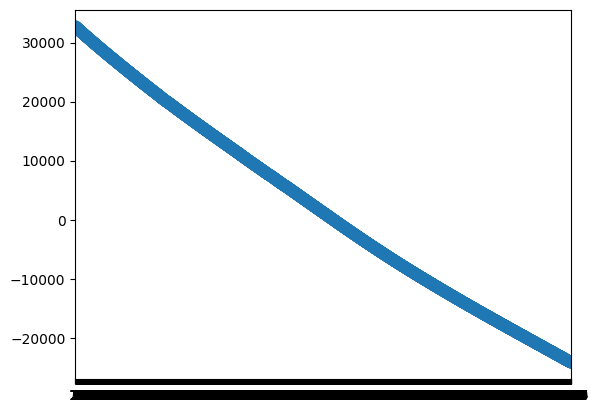

In [29]:
sns.pointplot(x=np.arange(3000), y=obj_clust.losses) 

In [30]:
print(obj_clust.groups) 
print(obj_clust.init_params["init_clusters"]) 

[3 3 3 0 3 3 3 1 1 1 1 5 3 3 1 0 5 1 1 0 0 1 1 5 0 1 3 1 0 0 5 0 0 0 0 1 0
 1 0 0 1 3 3 1 0 0 0 0 3 3 3 5 5 0 5 0 5 5 0 3 0 5 3 1 1 1 0 3 5 0 1 1 0 3
 5 5 5 0 0 0 0 5 0 0 5 0 0 0 0 4 4 4 0 4 0 0 0 0 0 0 0 0 4 0 0 0 0 4 0 0 0
 0 4 0 0 0 0 0 0 4 0 0 0 0 4 0 0 0 4 0 0 0 0 0 4 4 0 0 0 4 4 0 0 0 4 0 0 0
 0 0]
[3 3 3 3 3 3 3 1 1 1 1 1 2 1 1 1 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 2 1 2 2 1 1
 1 1 1 1 1 1 1 2 2 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 2 1 1 2 1 1 1
 5 5 5 0 5 5 5 5 5 5 0 0 4 4 4 4 4 4 4 0 4 4 4 4 4 0 4 0 4 0 4 0 4 4 4 4 4
 0 0 4 0 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 0 4 4 0 4 4 4 4 0 4 4 4 4 4 4 0
 4 4]


In [ ]:
from scipy.optimize import fsolve, minimize_scalar

def _compute_dirichlet_variance(alpha):
    alpha_hat = np.sum(alpha)
    num = alpha * (alpha_hat - alpha)
    denomin = alpha_hat**2 * (alpha_hat + 1)
    return num / denomin

def variance_condition(C, target, alpha):
    variances = _compute_dirichlet_variance(alpha * C)
    # print(f"C={C}, max diff={max(np.abs(variances - target))}")
    return max(np.abs(variances - target))

# Initial guess for C
initial_C = 1
# Calculate the smallest C for the given alpha and Y
alpha = obj_clust.params["alpha_prior"].values[0, :7]
target = obj_clust.init_params["variances"].values[0, :7]

# Solve for C
C_solution = minimize_scalar(fun=variance_condition, method="Bounded", bounds=(1,500), args=(target, alpha))
C_solution.x

In [ ]:
from scipy.optimize import fsolve

def dirichlet_variance(alpha, alpha_hat):
    # alpha_hat = np.sum(alpha)
    num = alpha * (alpha_hat - alpha)
    denomin = alpha_hat**2 * (alpha_hat + 1)
    return num / denomin

def optim_fn(c, true_var, alpha, alpha_hat):
    variances = dirichlet_variance(alpha=alpha*c, alpha_hat=alpha_hat*c)
    return np.abs(true_var - variances) + 1.0


In [ ]:
alpha = dist.Dirichlet(torch.ones(5)).sample().numpy()
true_var = np.ones(5) * 1e-4 
print(f"alpha = {alpha}, true_var = {true_var}")
sols = fsolve(func=optim_fn, x0=1.0, args=(true_var[0], alpha[0], np.sum(alpha))) 

In [ ]:
def solver(target, alpha_hat, alpha_k):
    a = target*alpha_hat**3
    b = target*alpha_hat**2
    c = alpha_k**2 - alpha_k*alpha_hat

    d = np.sqrt(b**2 - 4*a*c)
    xs = np.array([(-b + d) / (2*a), (-b - d) / (2*a)])
    return np.amax(xs)

c = solver(target=true_var[0], alpha_hat=1, alpha_k=alpha[0])

In [ ]:
dirichlet_variance(alpha=alpha, alpha_hat=alpha.sum()) 